<a href="https://colab.research.google.com/github/kridtapon/CI-CCI-Momentum-Strategy/blob/main/CI_CCI_Momentum_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.0 MB/s eta 0:00:00


In [ ]:
pip install --upgrade yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate Choppiness Index (CI)
def calculate_choppiness_index(df, period=14):
    high_low_range = df['High'] - df['Low']
    price_range = df['High'] - df['Low']

    choppiness_index = 100 * np.log10(price_range.rolling(window=period).sum()) / np.log10(period)

    return choppiness_index

# Function to calculate Commodity Channel Index (CCI)
def calculate_cci(df, period=20):
    # Typical Price = (High + Low + Close) / 3
    df['TypicalPrice'] = (df['High'] + df['Low'] + df['Close']) / 3

    # Moving Average of the Typical Price
    df['MA_Typical'] = df['TypicalPrice'].rolling(window=period).mean()

    # Mean Deviation
    df['MeanDev'] = df['TypicalPrice'].rolling(window=period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)

    # CCI Calculation
    df['CCI'] = (df['TypicalPrice'] - df['MA_Typical']) / (0.015 * df['MeanDev'])

    return df['CCI']

# Define the stock symbol and time period
symbol = 'VRTX'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate Choppiness Index (CI)
df['CI'] = calculate_choppiness_index(df)

# Calculate Commodity Channel Index (CCI)
df['CCI'] = calculate_cci(df)

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Define Entry and Exit signals based on CI and CCI
df['Entry'] = (df['CI'] > df['CI'].shift(30)) & (df['CCI'] < -100)
df['Exit'] = (df['CI'] < df['CI'].shift(30)) & (df['CCI'] > 100)

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           253600.249167
Total Return [%]                       153.600249
Benchmark Return [%]                    83.504223
Max Gross Exposure [%]                      100.0
Total Fees Paid                       6906.456265
Max Drawdown [%]                        18.567586
Max Drawdown Duration           220 days 00:00:00
Total Trades                                   19
Total Closed Trades                            18
Total Open Trades                               1
Open Trade PnL                      -29380.928466
Win Rate [%]                            88.888889
Best Trade [%]                          27.019127
Worst Trade [%]                         -5.914452
Avg Winning Trade [%]                    7.644123
Avg Losing Trade [%]                    -5.014204


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools

# Function to calculate Choppiness Index (CI)
def calculate_choppiness_index(df, period=14):
    high_low_range = df['High'] - df['Low']
    price_range = df['High'] - df['Low']

    choppiness_index = 100 * np.log10(price_range.rolling(window=period).sum()) / np.log10(period)

    return choppiness_index

# Function to calculate Commodity Channel Index (CCI)
def calculate_cci(df, period=20):
    # Typical Price = (High + Low + Close) / 3
    df['TypicalPrice'] = (df['High'] + df['Low'] + df['Close']) / 3

    # Moving Average of the Typical Price
    df['MA_Typical'] = df['TypicalPrice'].rolling(window=period).mean()

    # Mean Deviation
    df['MeanDev'] = df['TypicalPrice'].rolling(window=period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)

    # CCI Calculation
    df['CCI'] = (df['TypicalPrice'] - df['MA_Typical']) / (0.015 * df['MeanDev'])

    return df['CCI']

# Define the stock symbol and time period
symbol = 'VRTX'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Create a function to test different parameter combinations
def backtest_strategy(choppiness_period, cci_period, shift):
    # Calculate Choppiness Index (CI)
    df['CI'] = calculate_choppiness_index(df, period=choppiness_period)

    # Calculate Commodity Channel Index (CCI)
    df['CCI'] = calculate_cci(df, period=cci_period)

    # Filter data for the test period (2020-2025)
    df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    # Define Entry and Exit signals based on CI and CCI
    df_test['Entry'] = (df_test['CI'] > df_test['CI'].shift(shift)) & (df_test['CCI'] < -100)
    df_test['Exit'] = (df_test['CI'] < df_test['CI'].shift(shift)) & (df_test['CCI'] > 100)

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df_test['Close'],
        entries=df_test['Entry'],
        exits=df_test['Exit'],
        init_cash=100_000,
        fees=0.001,
        slippage=0.002,
        freq='D'
    )

    return portfolio.stats()

# Define the ranges for optimization
choppiness_period_range = range(10, 21)  # From 10 to 20
cci_period_range = range(10, 31)  # From 10 to 30
shift_range = range(5, 16)  # From 5 to 15

# Use itertools to generate all possible combinations of the parameters
param_combinations = itertools.product(choppiness_period_range, cci_period_range, shift_range)

# Initialize variables to store the best result
best_result = None
best_params = None

# Iterate over all parameter combinations and find the best result
for choppiness_period, cci_period, shift in param_combinations:
    stats = backtest_strategy(choppiness_period, cci_period, shift)

    # You can choose the performance metric here. Let's use the Total Return [%] as an example
    if best_result is None or stats['Total Return [%]'] > best_result['Total Return [%]']:
        best_result = stats
        best_params = (choppiness_period, cci_period, shift)

# Print the best result
print(f"Best Parameters: Choppiness Period: {best_params[0]}, CCI Period: {best_params[1]}, Shift: {best_params[2]}")
print("Best Portfolio Stats:", best_result)

# Optionally, plot the performance of the best strategy
df['CI'] = calculate_choppiness_index(df, period=best_params[0])
df['CCI'] = calculate_cci(df, period=best_params[1])
df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
df_test['Entry'] = (df_test['CI'] > df_test['CI'].shift(best_params[2])) & (df_test['CCI'] < -100)
df_test['Exit'] = (df_test['CI'] < df_test['CI'].shift(best_params[2])) & (df_test['CCI'] > 100)

# Backtest with the best parameters
portfolio = vbt.Portfolio.from_signals(
    close=df_test['Close'],
    entries=df_test['Entry'],
    exits=df_test['Exit'],
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Plot the equity curve of the best strategy
portfolio.plot().show()


Streaming output truncated to the last 5000 lines.
<ipython-input-41-562fcd0e9ad0>:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-41-562fcd0e9ad0>:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-41-562fcd0e9ad0>:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

KeyboardInterrupt: 

Streaming output truncated to the last 5000 lines.
<ipython-input-45-255baa82824c>:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-45-255baa82824c>:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-45-255baa82824c>:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

Best Parameters: Choppiness Period: 16.0, CCI Period: 25.0, Shift: 30.0
Best Portfolio Stats: Choppiness Period     16.000000
CCI Period            25.000000
Shift                 30.000000
Total Return         209.311989
Name: 4259, dtype: float64


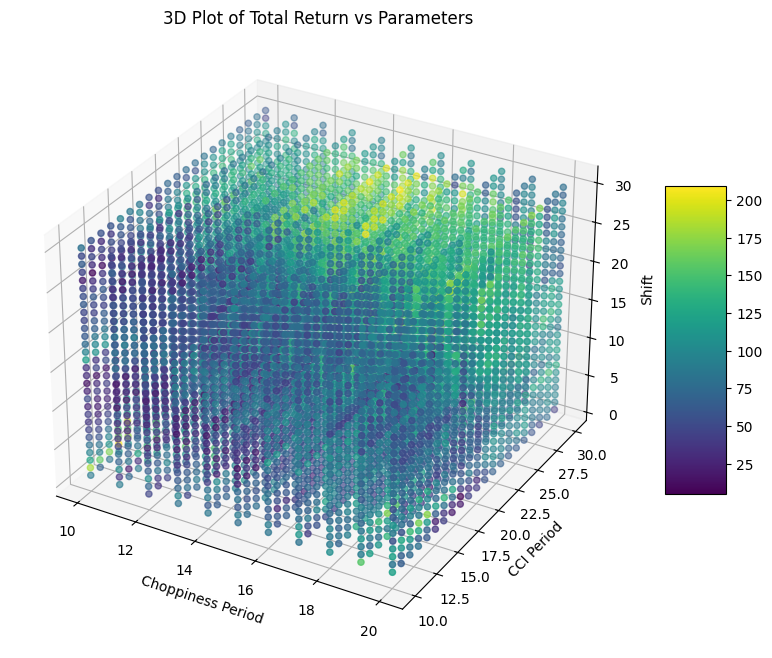

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to calculate Choppiness Index (CI)
def calculate_choppiness_index(df, period=14):
    period = int(period)
    high_low_range = df['High'] - df['Low']
    price_range = df['High'] - df['Low']
    choppiness_index = 100 * np.log10(price_range.rolling(window=period).sum()) / np.log10(period)
    return choppiness_index

# Function to calculate Commodity Channel Index (CCI)
def calculate_cci(df, period=20):
    period = int(period)
    df['TypicalPrice'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['MA_Typical'] = df['TypicalPrice'].rolling(window=period).mean()
    df['MeanDev'] = df['TypicalPrice'].rolling(window=period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    df['CCI'] = (df['TypicalPrice'] - df['MA_Typical']) / (0.015 * df['MeanDev'])
    return df['CCI']

# Define the stock symbol and time period
symbol = 'VRTX'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Create a function to test different parameter combinations
def backtest_strategy(choppiness_period, cci_period, shift):
    df['CI'] = calculate_choppiness_index(df, period=choppiness_period)
    df['CCI'] = calculate_cci(df, period=cci_period)
    df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
    df_test['Entry'] = (df_test['CI'] > df_test['CI'].shift(shift)) & (df_test['CCI'] < -100)
    df_test['Exit'] = (df_test['CI'] < df_test['CI'].shift(shift)) & (df_test['CCI'] > 100)

    portfolio = vbt.Portfolio.from_signals(
        close=df_test['Close'],
        entries=df_test['Entry'],
        exits=df_test['Exit'],
        init_cash=100_000,
        fees=0.001,
        slippage=0.002,
        freq='D'
    )
    return portfolio.stats()

# Define the ranges for optimization
choppiness_period_range = range(10, 21)  # From 10 to 20
cci_period_range = range(10, 31)  # From 10 to 30
shift_range = range(1, 31)  # From 1 to 30

# Use itertools to generate all possible combinations of the parameters
param_combinations = itertools.product(choppiness_period_range, cci_period_range, shift_range)

# Initialize variables to store results for plotting
results = []

# Iterate over all parameter combinations and collect stats
for choppiness_period, cci_period, shift in param_combinations:
    stats = backtest_strategy(choppiness_period, cci_period, shift)
    total_return = stats['Total Return [%]']
    results.append((choppiness_period, cci_period, shift, total_return))

# Convert the results to a DataFrame
results_df = pd.DataFrame(results, columns=['Choppiness Period', 'CCI Period', 'Shift', 'Total Return'])

# Find the best result
best_result = results_df.loc[results_df['Total Return'].idxmax()]
best_params = best_result[['Choppiness Period', 'CCI Period', 'Shift']].values
print(f"Best Parameters: Choppiness Period: {best_params[0]}, CCI Period: {best_params[1]}, Shift: {best_params[2]}")

# Plot the 3D optimization results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the parameters vs. total return
ax.scatter(
    results_df['Choppiness Period'],
    results_df['CCI Period'],
    results_df['Shift'],
    c=results_df['Total Return'],
    cmap='viridis',
    marker='o'
)

ax.set_xlabel('Choppiness Period')
ax.set_ylabel('CCI Period')
ax.set_zlabel('Shift')
ax.set_title('3D Plot of Total Return vs Parameters')

# Show color bar to indicate the total return scale
fig.colorbar(ax.collections[0], ax=ax, shrink=0.5, aspect=5)

plt.show()

In [ ]:
# Plot the performance of the best strategy
df['CI'] = calculate_choppiness_index(df, period=16)
df['CCI'] = calculate_cci(df, period=25)

df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

df_test['Entry'] = (df_test['CI'] > df_test['CI'].shift(30)) & (df_test['CCI'] < -100)
df_test['Exit'] = (df_test['CI'] < df_test['CI'].shift(30)) & (df_test['CCI'] > 100)

# Backtest with the best parameters
portfolio = vbt.Portfolio.from_signals(
    close=df_test['Close'],
    entries=df_test['Entry'],
    exits=df_test['Exit'],
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Plot the equity curve of the best strategy
portfolio.plot().show()

print(portfolio.stats())

<ipython-input-46-c1dd1fe301a9>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-46-c1dd1fe301a9>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           309311.989157
Total Return [%]                       209.311989
Benchmark Return [%]                    83.504223
Max Gross Exposure [%]                      100.0
Total Fees Paid                       7250.649213
Max Drawdown [%]                        18.567586
Max Drawdown Duration           114 days 00:00:00
Total Trades                                   18
Total Closed Trades                            17
Total Open Trades                               1
Open Trade PnL                      -49463.825671
Win Rate [%]                            94.117647
Best Trade [%]                          27.019127
Worst Trade [%]                         -4.072539
Avg Winning Trade [%]                    8.905421
Avg Losing Trade [%]                    -4.072539


[*********************100%***********************]  1 of 1 completed


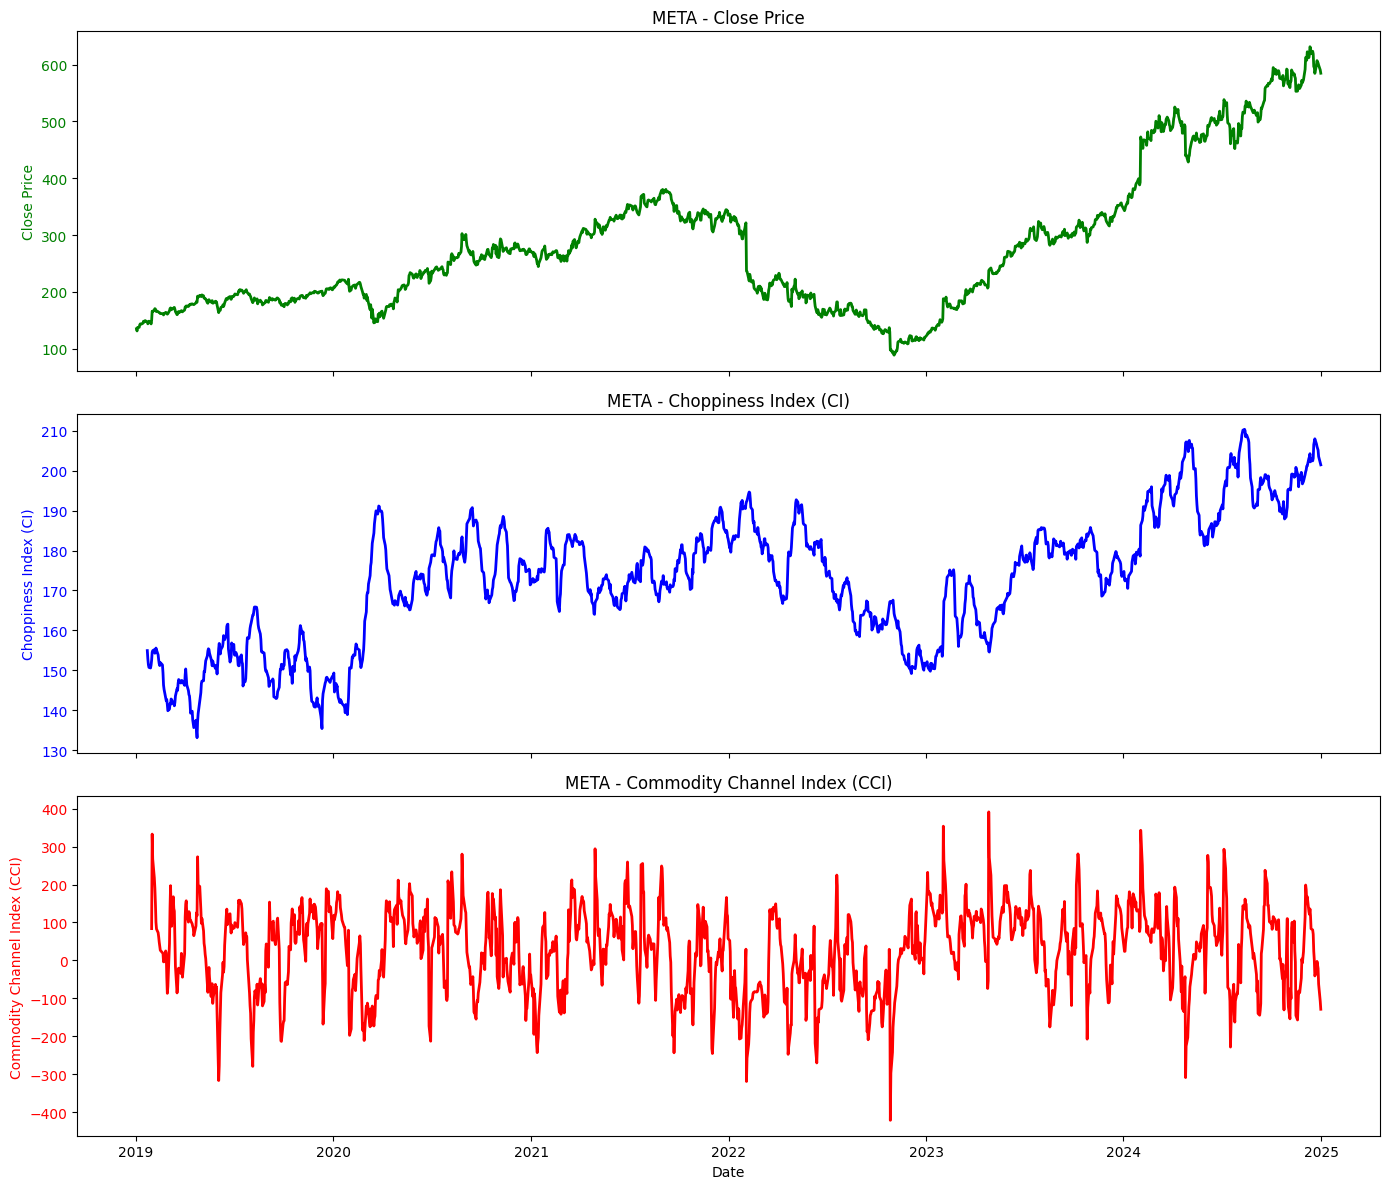

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Function to calculate Choppiness Index (CI)
def calculate_choppiness_index(df, period=14):
    high_low_range = df['High'] - df['Low']
    price_range = df['High'] - df['Low']

    choppiness_index = 100 * np.log10(price_range.rolling(window=period).sum()) / np.log10(period)

    return choppiness_index

# Function to calculate Commodity Channel Index (CCI)
def calculate_cci(df, period=20):
    # Typical Price = (High + Low + Close) / 3
    df['TypicalPrice'] = (df['High'] + df['Low'] + df['Close']) / 3

    # Moving Average of the Typical Price
    df['MA_Typical'] = df['TypicalPrice'].rolling(window=period).mean()

    # Mean Deviation
    df['MeanDev'] = df['TypicalPrice'].rolling(window=period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)

    # CCI Calculation
    df['CCI'] = (df['TypicalPrice'] - df['MA_Typical']) / (0.015 * df['MeanDev'])

    return df['CCI']

# Define the stock symbol and time period
symbol = 'VRTX'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate Choppiness Index (CI)
df['CI'] = calculate_choppiness_index(df)

# Calculate Commodity Channel Index (CCI)
df['CCI'] = calculate_cci(df)

# Plotting the Close Price, Choppiness Index (CI), and Commodity Channel Index (CCI) on separate panels
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot Close Price on the first panel
ax1.plot(df.index, df['Close'], color='green', label='Close Price', linewidth=2)
ax1.set_ylabel('Close Price', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_title(f"{symbol} - Close Price")

# Plot CI on the second panel
ax2.plot(df.index, df['CI'], color='blue', label='Choppiness Index (CI)', linewidth=2)
ax2.set_ylabel('Choppiness Index (CI)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_title(f"{symbol} - Choppiness Index (CI)")

# Plot CCI on the third panel
ax3.plot(df.index, df['CCI'], color='red', label='Commodity Channel Index (CCI)', linewidth=2)
ax3.set_xlabel('Date')
ax3.set_ylabel('Commodity Channel Index (CCI)', color='red')
ax3.tick_params(axis='y', labelcolor='red')
ax3.set_title(f"{symbol} - Commodity Channel Index (CCI)")

# Title and layout adjustments
fig.tight_layout()

# Show the plot
plt.show()
